Climate data is unique because it is usually **multi-dimensional**. A single file might contain temperature data that varies by:
1. **Latitude** (North-South)
2. **Longitude** (East-West)
3. **Time** (Days, Months, Years)

Standard programming tools (like Excel or basic Python lists) struggle with this. Today, we will learn standard libraries used by climate scientists worldwide:

* **Xarray:** For handling labeled multi-dimensional arrays (N-dimensional arrays).
* **Cartopy:** For plotting data on a spherical Earth (map projections).

### Learning Objectives
By the end of this tutorial, you will be able to:
1.  Load NetCDF files (the standard file format for climate data).
2.  Slice data by **label** (e.g., "Give me data for January 2015") rather than index.
3.  Calculate **weighted global averages** (correcting for the spherical shape of the Earth).
4.  Create map visualizations using projections.

In [2]:
import xarray
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



We will look at **Outgoing Longwave Radiation (OLR)** data from the CERES satellite. This represents the energy Earth is losing to space.

Normally, if you wanted the 10th latitude and 50th longitude, you might type `data[10, 50]`. This is dangerous! You have to remember which index corresponds to which location.

**Xarray** solves this by letting us use **Labels**.

In [8]:
# Open the dataset
ds = xarray.open_dataset('Datasets/CERES_TOA_OutgoingLW.nc')

# Print the dataset to screen to inspect it
ds

<xarray.Dataset> Size: 34MB
Dimensions:         (time: 130, lat: 180, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 1kB 2010-03-15 ... 2020-12-15
  * lat             (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    toa_lw_all_mon  (time, lat, lon) float32 34MB ...
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date June 8, 2021
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1

### Inspecting the Output
Look at the output above. Notice two key sections:
1.  **Dimensions:** This tells you the shape of the data (e.g., 180 latitudes, 360 longitudes, and 130 time).
2.  **Coordinates:** These are the **labels**. It tells you that `lat` goes from -89.5 to 89.5.

Let's extract the actual variable we want to work with: `toa_lw_all_mon` (Top of Atmosphere Longwave All-Sky Monthly).

In [9]:
olr = ds.toa_lw_all_mon

## Slicing and Dicing (Selection)

Because xarray knows the coordinates, we can ask for data using physical values.

### Selecting a Single Point
Let's find the radiation data for a point near Pune, India (approx 18.5°N, 73.8°E). 

Note the use of `method='nearest'`. Since our data is on a grid (e.g., 17.5, 18.5, 19.5), the exact value 18.52 might not exist. `nearest` tells xarray to grab the closest available grid point.

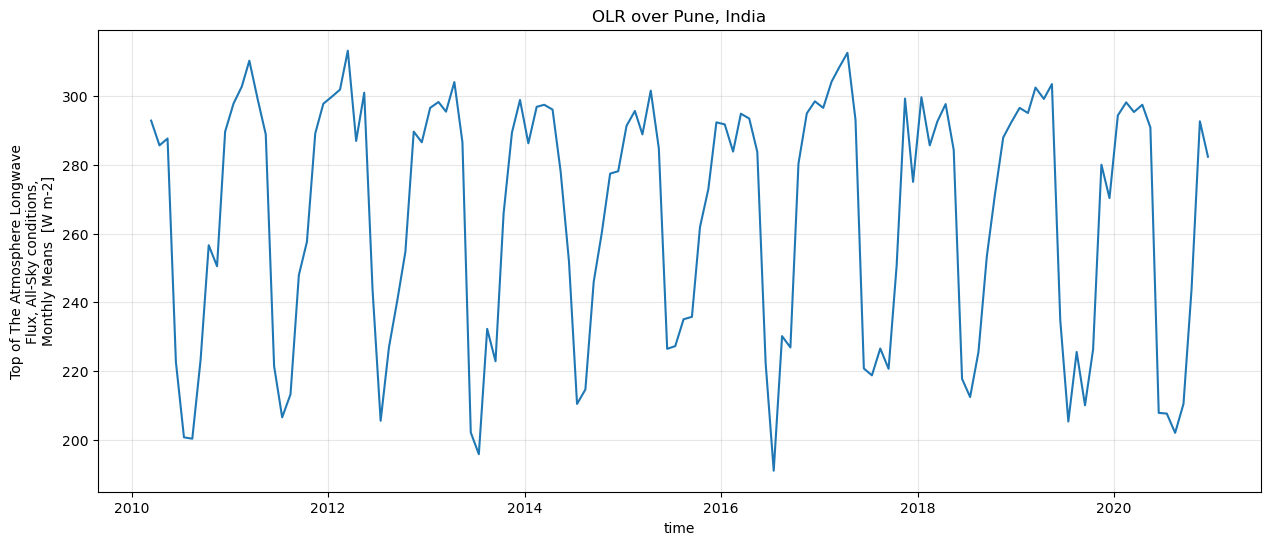

In [14]:
# Select a specific point
pune_data = olr.sel(lat=18.5, lon=73.8, method='nearest')

# Plot the result (Time Series)
plt.figure(figsize=(15, 6))
pune_data.plot()
plt.title("OLR over Pune, India")
plt.grid(alpha=0.3)
plt.show()

### Selecting a Region (Slicing)
We can also select a range of values using `slice`. Grab **Tropics** (between -30 and +30 latitude).

In [15]:
# Select the tropics
tropics = olr.sel(lat=slice(-30, 30))

# Check the size - notice the 'lat' dimension is smaller now
print("Original shape:", olr.shape)
print("Tropics shape:", tropics.shape)

Original shape: (130, 180, 360)
Tropics shape: (130, 60, 360)


## "Flat Earth" vs. Weighted Means

If we want to calculate the **Global Average OLR**, you might be tempted to just run `.mean()`. **This is physically incorrect.**

### The Problem
Our data is on a Latitude/Longitude grid. 
* A $1^\circ \times 1^\circ$ box at the **Equator** is very large (approx $111km \times 111km$).
* A $1^\circ \times 1^\circ$ box at the **North Pole** is tiny (area approaches zero).

If we take a simple mean, we treat the tiny polar boxes as equal to the huge equatorial boxes. We need to **weight** the data by the area of the grid cells.

### Solution: Cosine Weighting
The area of a grid cell on a sphere is proportional to the cosine of the latitude: $Area \propto \cos(lat)$.

In [18]:
# Create the weights
# We convert latitude to radians first, because numpy functions expect radians
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# Apply the weights to the dataset
olr_weighted = olr.weighted(weights)

# 3. Compute the means
simple_mean = olr.mean(dim=['lat', 'lon', 'time'])
correct_mean = olr_weighted.mean(dim=['lat', 'lon', 'time'])

print(f"Simple Mean: {simple_mean.values:.2f} W/m^2")
print(f"Weighted Mean: {correct_mean.values:.2f} W/m^2")
print(f"Difference: {abs(simple_mean - correct_mean).values:.2f} W/m^2")

Simple Mean: 225.04 W/m^2
Weighted Mean: 240.51 W/m^2
Difference: 15.47 W/m^2


## Reducing Dimensions (Zonal Means)

Often we want to collapse dimensions to see trends. A **Zonal Mean** averages the data across all longitudes, leaving us with a profile of how a variable changes from North to South.

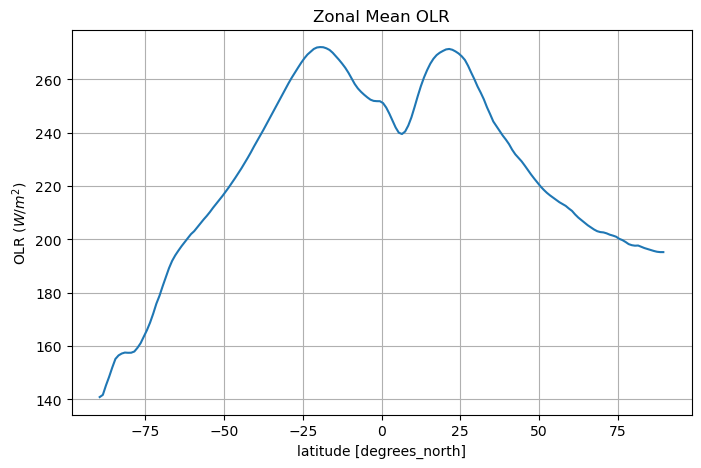

In [19]:
# Average over the 'lon' dimension and 'time' dimension
zonal_mean_profile = olr.mean(dim=['lon', 'time'])

# Plot
plt.figure(figsize=(8, 5))
zonal_mean_profile.plot()
plt.title("Zonal Mean OLR")
plt.ylabel("OLR ($W/m^2$)")
plt.grid(True)
plt.show()

## Making it Geographic (Cartopy)

Finally, let's make a map. We use `cartopy` to handle the projection (transforming the spherical earth onto a flat screen).

There are two key arguments you will see:
1.  `projection=...`: How we **view** the map (e.g., Robinson, Mollweide, PlateCarree).
2.  `transform=...`: How the data is **stored**. Since our data is a grid of Lat/Lon, it corresponds to the PlateCarree format.

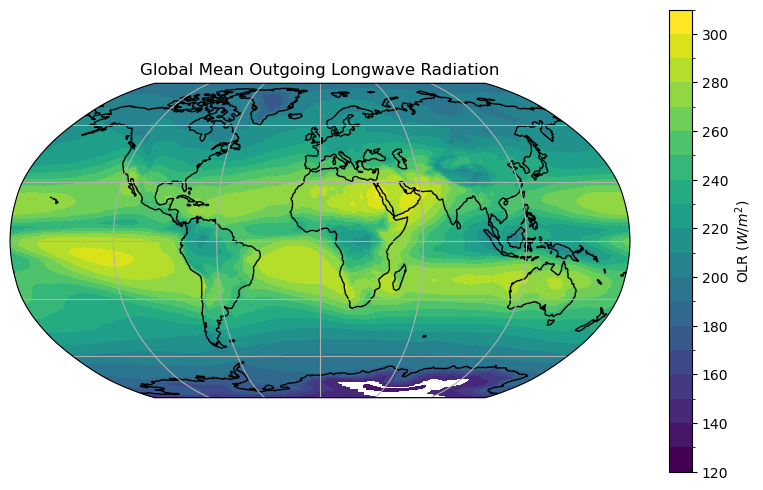

In [35]:
# Create a Time Mean (Average map over all years)
map_data = olr.mean(dim='time')

# Setup the plot with a projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot the data
# We MUST specify transform=ccrs.PlateCarree() so cartopy knows the data is lat/lon
# We use .plot.contourf() for filled contours instead of the default heatmap
map_data.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                       cbar_kwargs={'label': 'OLR ($W/m^2$)'},
                       levels=20)

# Add coastlines for context
ax.coastlines()
ax.gridlines()

plt.title("Global Mean Outgoing Longwave Radiation")
plt.show()

## Radiating Temperature

The Earth radiates energy like a Blackbody. The **Stefan-Boltzmann Law** tells us how energy ($E$) relates to temperature ($T$):

$$ E = \sigma T^4 $$

where $\sigma \approx 5.67 \times 10^{-8} \, W \, m^{-2} \, K^{-4}$ is the Stefan-Boltzmann constant.

If we have the Energy ($E$), we can rearrange this to find the "Radiating Temperature" ($T_{rad}$) of the Earth:

$$ T_{rad} = \left( \frac{E}{\sigma} \right)^{1/4} $$


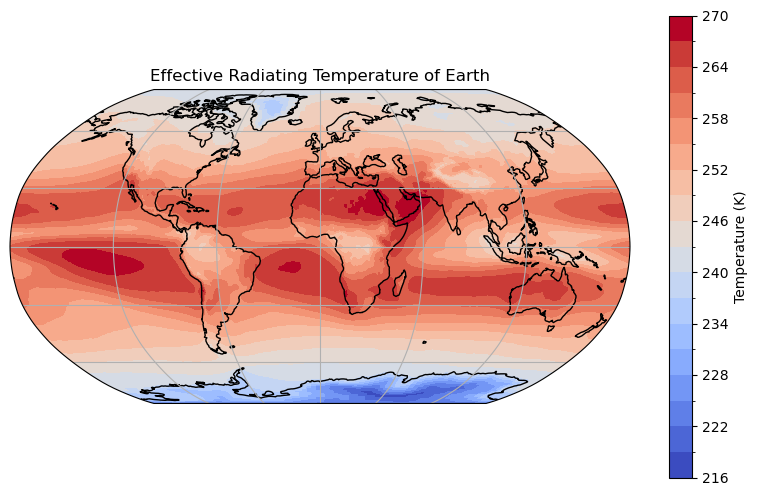

In [37]:
# Define the constant
sigma = 5.67e-8

# Apply the formula to our entire map of data
T_rad = (map_data / sigma)**0.25

# Plot the result
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

T_rad.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                    cbar_kwargs={'label': 'Temperature (K)'},
                    levels=20,
                    cmap='coolwarm') 

ax.coastlines()
ax.gridlines()

plt.title("Effective Radiating Temperature of Earth")
plt.show()

## Exercise

We have another dataset: `CERES_TOA_OutgoingSW.nc` which contains the **Reflected Shortwave Radiation**.

**Tasks:**
1.  Load the Shortwave dataset.
2.  Select only the data for the year **2010**.
3.  Create cosine weights.
4.  Compute the **Weighted Global Mean** of reflected radiation for 2010.
5.  *Bonus:* Calculate the **Planetary Albedo** for 2010. 
    * *Hint:* Albedo = (Reflected Solar) / (Incoming Solar).
    * *Hint:* Assume Incoming Solar (S/4) is roughly 340 W/m².

In [3]:
dataset = xarray.open_dataset('Datasets/CERES_TOA_OutgoingSW.nc')

dataset

<xarray.Dataset> Size: 34MB
Dimensions:         (time: 130, lat: 180, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 1kB 2010-03-15 ... 2020-12-15
  * lat             (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    toa_sw_all_mon  (time, lat, lon) float32 34MB ...
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date June 8, 2021
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1

In [7]:
osw = dataset.toa_sw_all_mon
osw_2010 = osw.sel(time='2010')
osw_2010

<xarray.DataArray 'toa_sw_all_mon' (time: 10, lat: 180, lon: 360)> Size: 3MB
[648000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 80B 2010-03-15 2010-04-15 ... 2010-12-15
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Top of The Atmosphere Shortwave Flux, All-Sky conditions,...
    standard_name:  TOA Shortwave Flux - All-Sky
    CF_name:        toa_outgoing_shortwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            600.000

In [13]:
weights = np.cos(np.deg2rad(dataset.lat))
weights.name = "weights"

osw_weighted_2010 = osw_2010.weighted(weights)

mean = osw_weighted_2010.mean(dim=['lat', 'lon', 'time'])
print(f"Weighted Mean Reflected SW: {mean.values:.2f} W/m^2")

Weighted Mean Reflected SW: 98.58 W/m^2


In [12]:
albedo = mean / 340
print(f"Estimated Planetary Albedo for 2010: {albedo.values:.3f}")

Estimated Planetary Albedo for 2010: 0.290
